In [ ]:
# GDrive mount (required only if being run on GDrive)
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# importing dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# importing DL dependencies
import keras

In [ ]:
##### PLEASE SET THESE CAREFULLY refer :instructions.txt

MODEL_DIR = "/gdrive/Shareddrives/DLNN_ProjC1/output/final_c2_models"
INPUT_DIR = "/gdrive/Shareddrives/DLNN_ProjC1/output/sync_data_ishan/test"
OUTPUT_DIR = "/gdrive/Shareddrives/DLNN_ProjC1/output/final_output"

NORMALIZE_DIR = "/gdrive/Shareddrives/DLNN_ProjC1/output/data_sampling_ishan"
#####


# some constants
X_NAMES = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
TIME = ["TIME"]
CLASS = ["CLASS"]
SEQUENCE_SIZE = 160
POST_PROCESS_WINDOW = 10

In [ ]:
# loading the normalization-data

mean = np.load(os.path.join(NORMALIZE_DIR, "x_mean.npy"))
std = np.load(os.path.join(NORMALIZE_DIR, "x_stddev.npy"))


In [ ]:
# utility functions
def my_mode(np_array, return_counts=False):
  uniques, counts = np.unique(np_array, return_counts=True)
  # print(uniques, counts)
  
  cnts = [0,0,0,0]
  for i in range(uniques.shape[0]):
    cnts[i] = counts[i]
  
  counts = np.array(cnts)
  mode_indx = np.argmax(counts)


  if not return_counts:
    return uniques[mode_indx]
  return uniques[mode_indx], cnts
  

def normalize_z(x, avg, std_dev, smooth = 0.0001):
  return (x-avg) / (std_dev + smooth)

In [ ]:
# loading all models

models = []
outputs = {}

for filename in os.listdir(MODEL_DIR):
  if "h5" in filename:
    temp_model = keras.models.load_model(os.path.join(MODEL_DIR, filename), compile = False)
    models.append(temp_model)
    

print("number of models: ", len(models))
NUMBER_MODELS = len(models)

for i in range(-1, NUMBER_MODELS):
  outputs[i] = {}  

models[0].summary()

number of models:  21
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 160, 6)]          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 160, 25)           475       
_________________________________________________________________
dropout_60 (Dropout)         (None, 160, 25)           0         
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 80, 25)            0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 80, 50)            3800      
_________________________________________________________________
dropout_61 (Dropout)         (None, 80, 50)            0         
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 

In [ ]:
# generating preds 
for model_number in range(len(models)):
  for test_input_file in sorted(os.listdir(INPUT_DIR)):
    prefix = test_input_file[:15]

    test_input = np.array(pd.read_csv(os.path.join(INPUT_DIR, test_input_file)))


    test_rows = test_input.shape[0]

    test_input_x = test_input[:, :6]
    test_output_x = test_input[:, 6]

    outputs[-1][test_input_file] = test_output_x[::4]

    test_input_x = normalize_z(test_input_x, mean, std)
    

    done_index = 0
    test_input_batch = []
    
    while done_index + SEQUENCE_SIZE < test_rows:
      test_input_batch.append(test_input_x[done_index: done_index + SEQUENCE_SIZE])
      done_index += SEQUENCE_SIZE

    test_input_batch.append(test_input_x[-SEQUENCE_SIZE:])
    test_input_batch = np.array(test_input_batch)  


      
    test_output_preds = models[model_number].predict(test_input_batch)
    test_output_sparse = np.argmax(test_output_preds, axis = -1)


    op = np.zeros(shape = (1,), dtype = np.uint8)
    
    for i in range(test_output_sparse.shape[0] - 1):
      op = np.concatenate((op, test_output_sparse[i]), axis = 0)
    

    left_out = test_rows - op.shape[0]

    op = np.concatenate((op, test_output_sparse[-1][-left_out-1:]), axis = 0)

    op = op[1:]
    new_op = []


    indx = 0
    while indx < op.shape[0] - 4:
      new_op.append(my_mode(op[indx: indx+4], return_counts=False))
      indx += 4
    
    new_op.append(my_mode(op[indx:]))

    op = np.array(new_op)

    

    outputs[model_number][test_input_file] = op[:]


  

(9498,)


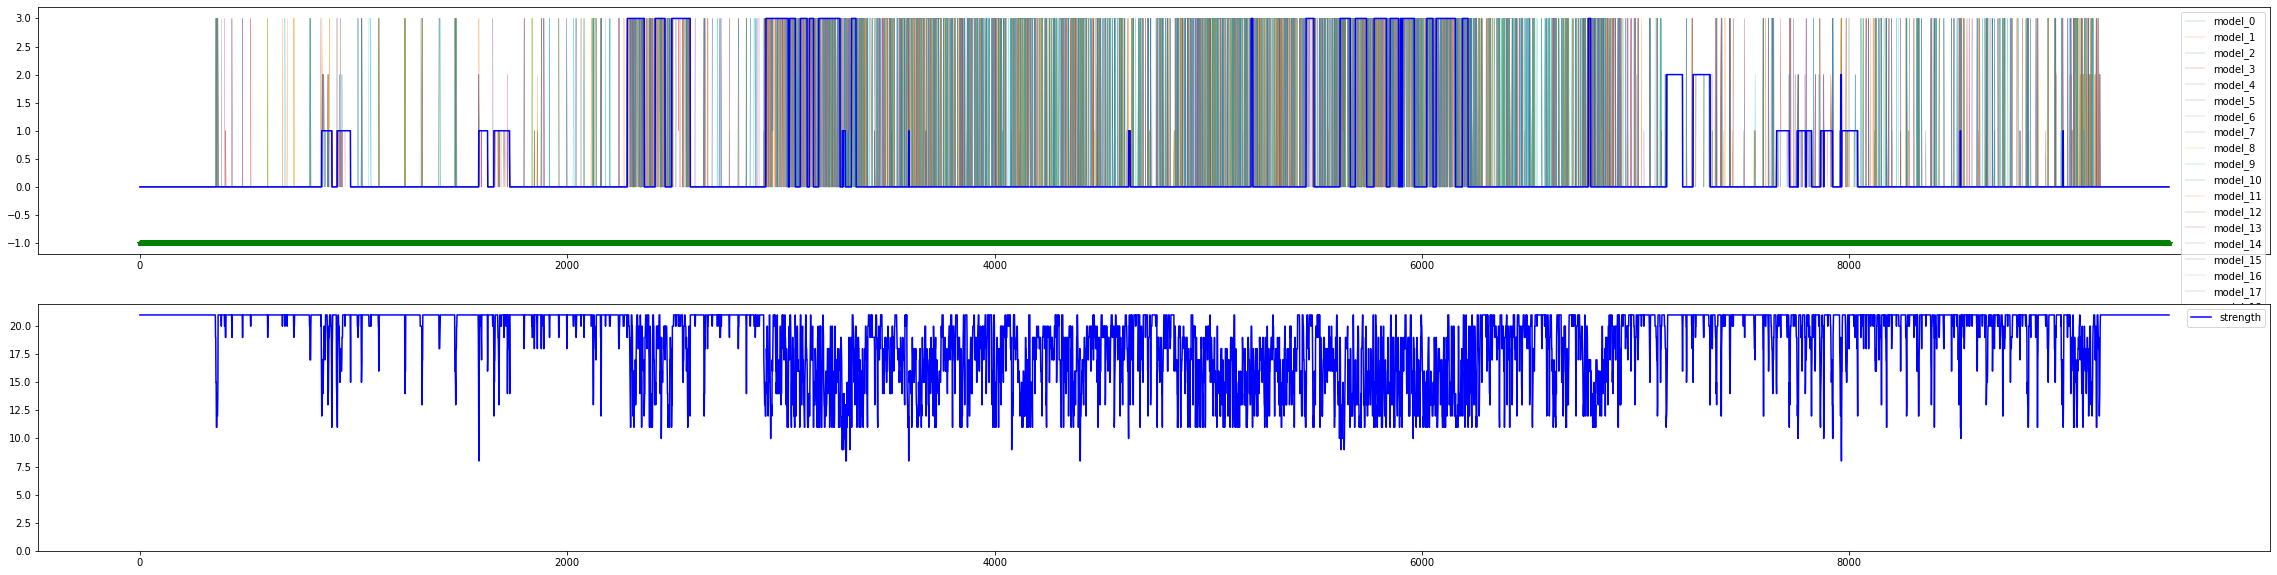

0    7862
3     977
1     501
2     158
Name: LABEL, dtype: int64
(12270,)


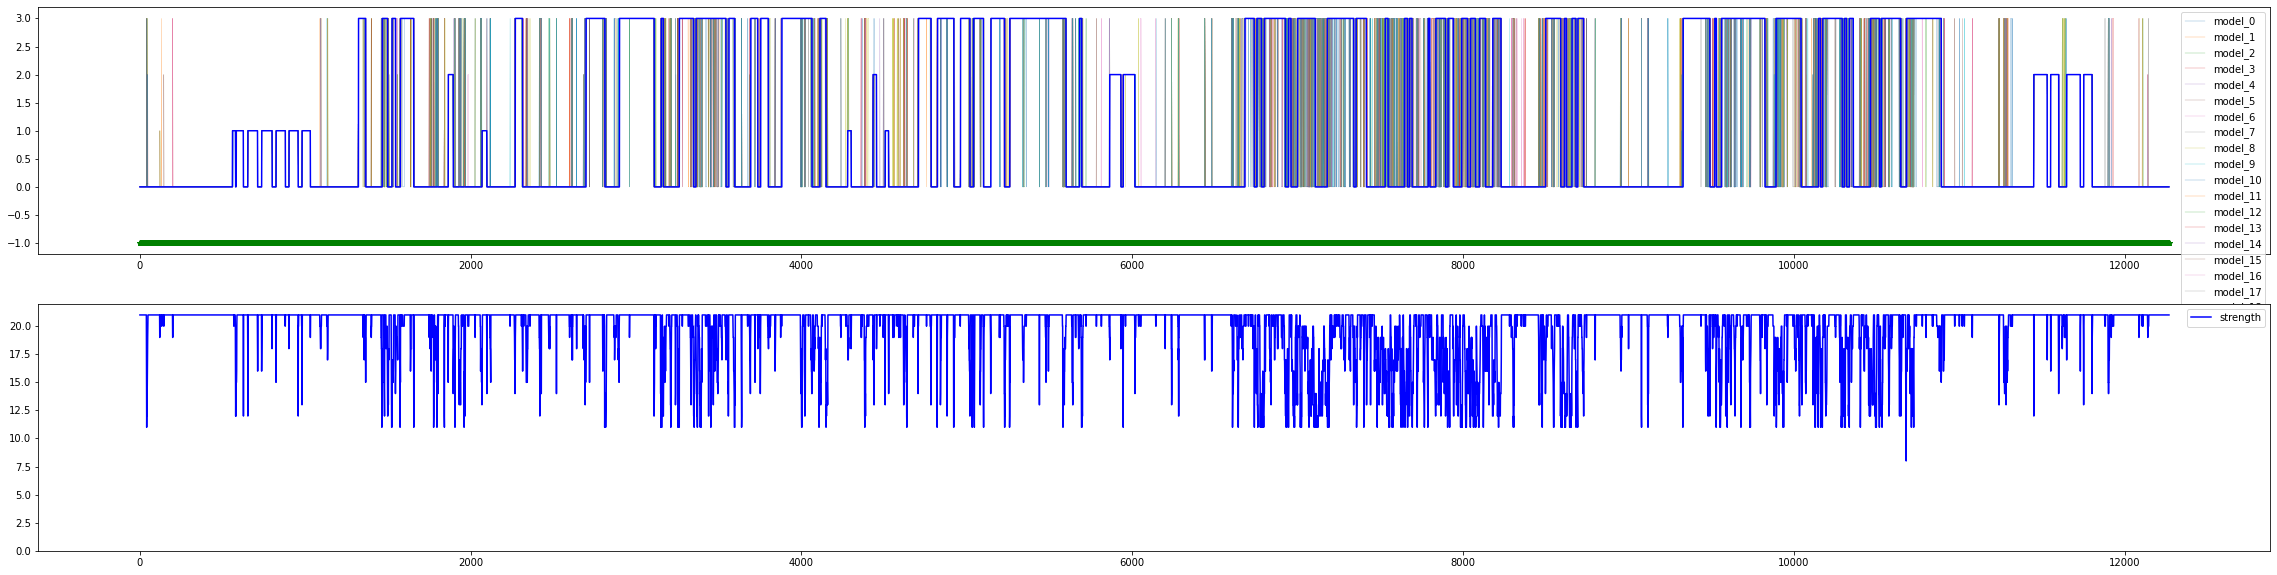

0    7357
3    4044
2     452
1     417
Name: LABEL, dtype: int64
(12940,)


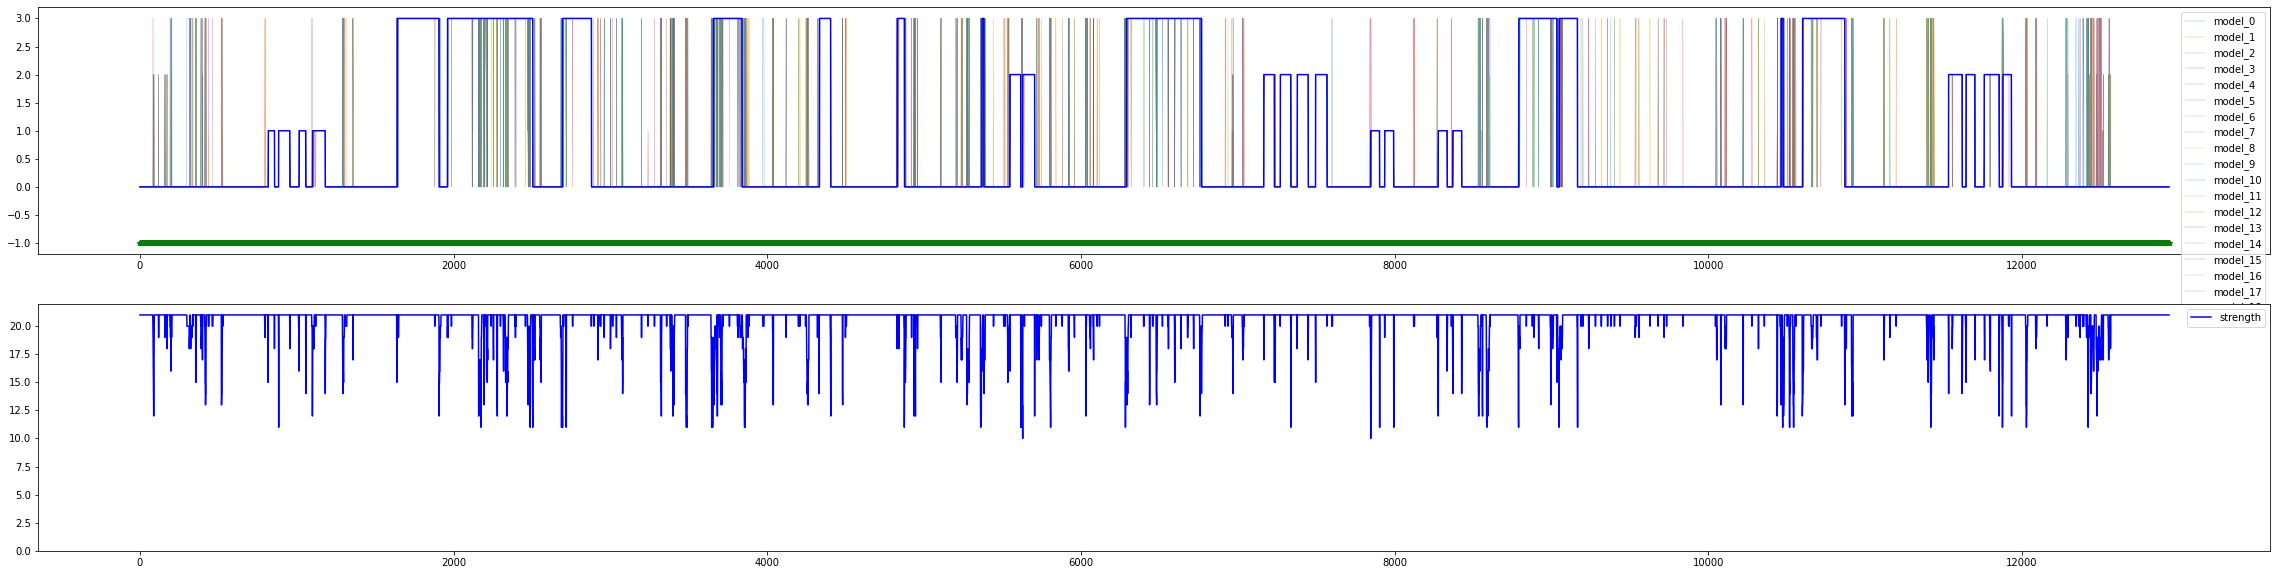

0    9336
3    2425
2     716
1     463
Name: LABEL, dtype: int64
(11330,)


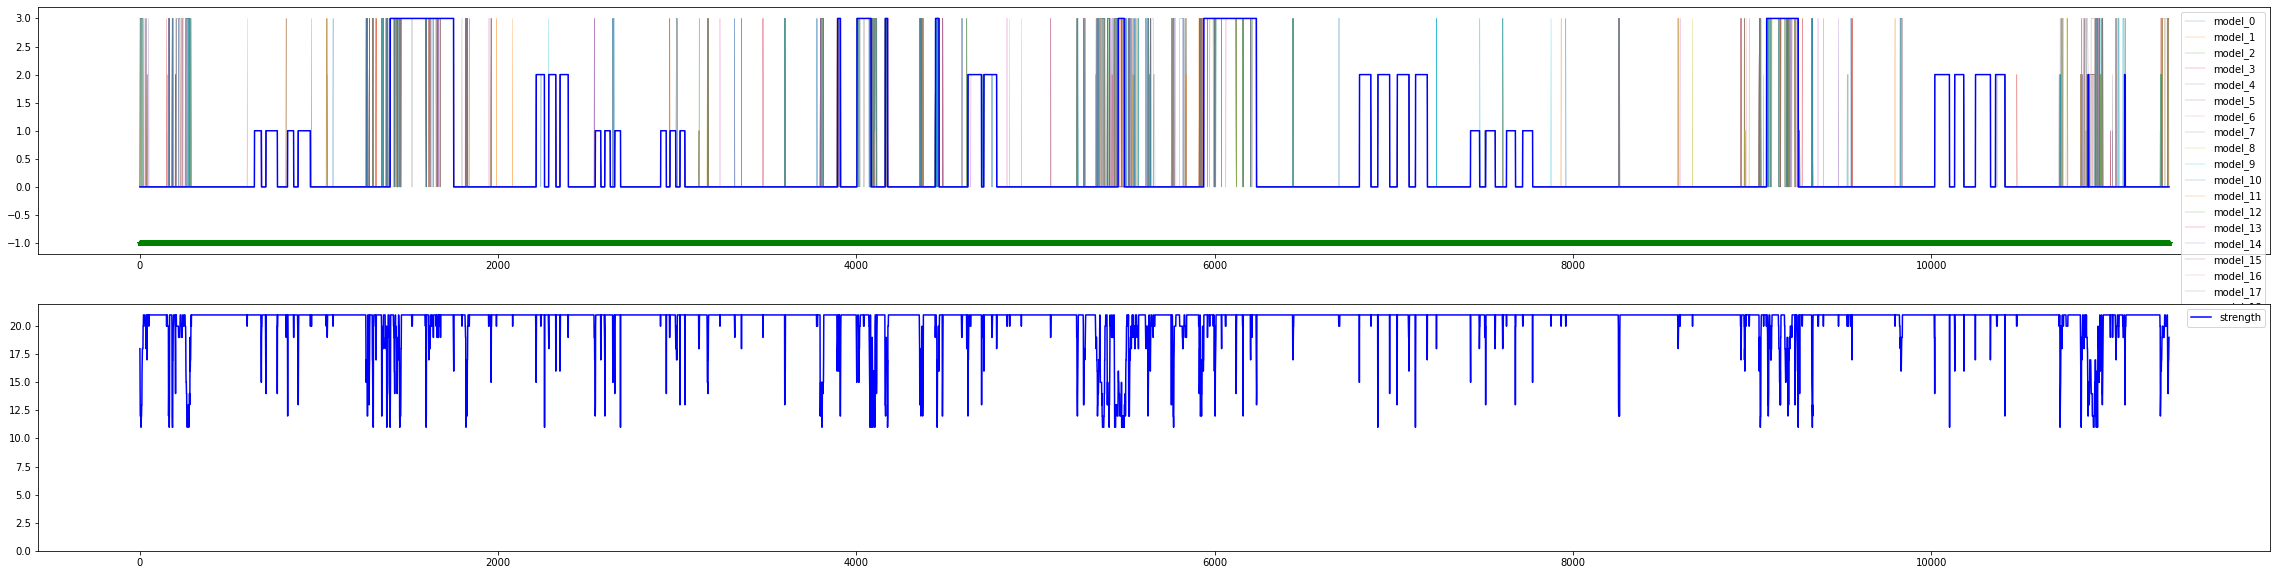

0    8927
3     987
2     818
1     598
Name: LABEL, dtype: int64


In [ ]:
# now post-processing and writing to file + plot outputs

START = 0
UPTO = -1


for test_input_file in os.listdir(INPUT_DIR):
  
  prefix = test_input_file[:15]
  out_file_name = prefix + "_y_prediction.csv"

  plt.figure(figsize=(40, 10))
  a1=plt.subplot(2,1,1)
  a2=plt.subplot(2,1,2)
  

  for model_number in range(NUMBER_MODELS):
    a1.plot(outputs[model_number][test_input_file][START:UPTO], linewidth=0.25, label = "model_" + str(model_number))
  a1.plot(outputs[-1][test_input_file][START:UPTO], linewidth=0.5,  marker = "*", color = "green", label = "GT")
  

  ensemble = np.zeros_like(outputs[model_number][test_input_file])
  counts =[[],[],[],[]]
  strength = []
  print(ensemble.shape)
  for i in range(ensemble.shape[0]):
    ensemble[i], temp = my_mode(np.array([outputs[k][test_input_file][i] for k in range(NUMBER_MODELS)]), return_counts=True)
    strength.append(max(temp))
    for k in range(4):
      counts[k].append(temp[k])


  
  conv_ens=[]
  for indx in range(ensemble.shape[0]):
      min_no = max(0, indx-POST_PROCESS_WINDOW)
      max_no = min(ensemble.shape[0]-1, indx+POST_PROCESS_WINDOW)

      md, cnts = my_mode(ensemble[min_no:max_no], return_counts=True)
      if md==3 or ensemble[indx]==3:
        if cnts[3] > 0.2* 2*POST_PROCESS_WINDOW:
          conv_ens.append(3)
        else:
          conv_ens.append(md)

      
      else:
        conv_ens.append(ensemble[indx])
      
  ensemble = np.array(conv_ens)
  conv_ens=[]
  for indx in range(ensemble.shape[0]):
      min_no = max(0, indx-POST_PROCESS_WINDOW)
      max_no = min(ensemble.shape[0]-1, indx+POST_PROCESS_WINDOW)

      md, cnts = my_mode(ensemble[min_no:max_no], return_counts=True)
      if md==3 or ensemble[indx]==3:
        if cnts[3] > 0.2* 2*(max_no-min_no):
          conv_ens.append(3)
        else:
          conv_ens.append(md)

      
      else:
        conv_ens.append(ensemble[indx])
      
  ensemble = np.array(conv_ens)
  a1.plot(ensemble[START:UPTO], color = "blue", label = "ensemble")
  

  
  a2.plot(strength[START:UPTO], color = "blue", label = "strength")
  a2.set_ylim(0, 22)

  a1.legend()
  a2.legend()
  plt.show()

  ensemble = pd.DataFrame(ensemble, columns=["LABEL"])

  ensemble.to_csv(os.path.join(OUTPUT_DIR, (out_file_name)) , header = False, index= False)
  ensemble.to_csv(os.path.join(".", (out_file_name)) , header = False, index= False)
  print(ensemble.LABEL.value_counts())
  
